# Automated Essay Scoring

Automated essay scoring (AES) is the use of specialized computer programs to assign grades to essays written in an educational setting. 
It is a method of educational assessment and an application of NLP.
The basic idea  is to search for features which can model attributes like language fluency, vocabulary, structure, organization, content


# Data Set Description

- The data consists of a training set of 12,976 essays
- The data consists of a validation set of 4,218 essays. 
- The data consists of a test set of 4,254 essays.

* It is divided into 8 essay sets such that each essay set had a unique topic and unique scoring system. 
* The average length of the essays differs for each set. ( 150 to 650 words )
* The essays were written by students ranging in grade 7 to grade 10. 
* All the essays were graded by at least 2 human graders. 
* The genres include persuasive, narrative, or source dependent responses. 


# Target Score = domain1_score
All essays have domain_1 attribute which represents a cumulative score provided by rater_1 and rater_2 based on writing application




# Exploratory Data Analysis




In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import re, collections
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-colorblind')

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', 100)


In [2]:
# Fetching training set

training_set  = pd.read_csv('kaggle-dataset/training_set_rel3.tsv', sep='\t', encoding = "ISO-8859-1", header=0)
training_set.sample()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
92,93,1,"Readers of ""@LOCATION2 @CAPS1"" should be well informed of the benifets of computers to society. ...",5,6,NaN,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 28 columns):
essay_id          12976 non-null int64
essay_set         12976 non-null int64
essay             12976 non-null object
rater1_domain1    12976 non-null int64
rater2_domain1    12976 non-null int64
rater3_domain1    128 non-null float64
domain1_score     12976 non-null int64
rater1_domain2    1800 non-null float64
rater2_domain2    1800 non-null float64
domain2_score     1800 non-null float64
rater1_trait1     2292 non-null float64
rater1_trait2     2292 non-null float64
rater1_trait3     2292 non-null float64
rater1_trait4     2292 non-null float64
rater1_trait5     723 non-null float64
rater1_trait6     723 non-null float64
rater2_trait1     2292 non-null float64
rater2_trait2     2292 non-null float64
rater2_trait3     2292 non-null float64
rater2_trait4     2292 non-null float64
rater2_trait5     723 non-null float64
rater2_trait6     723 non-null float64
rater3_trait1     128

In [5]:
# getting relevant columns
data = training_set[['essay_set','essay','domain1_score']].copy()

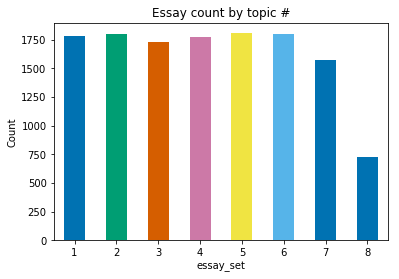

In [6]:
# Number of essays in each set

training_set.groupby('essay_set').agg('count').plot.bar(y='essay', rot=0, legend=False)
plt.title('Essay count by topic #')
plt.ylabel('Count')
plt.show()

Since topic 8 has the fewest essays and the most distinct scores, it might prove to be the most challenging topic to model.

In [7]:
# Count words for each essay

training_set['word_count'] = training_set['essay'].str.strip().str.split().str.len()

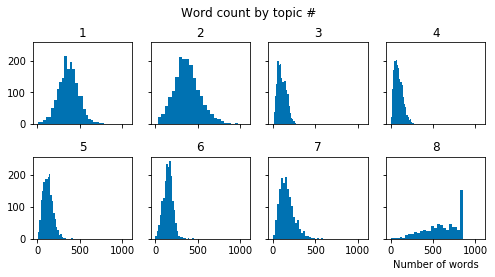

In [8]:
training_set.hist(column='word_count', by='essay_set', bins=25, sharey=True, sharex=True, layout=(2, 4), figsize=(7,4), rot=0) 
plt.suptitle('Word count by topic #')
plt.xlabel('Number of words')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [9]:
# Essay Set Metrics based on target score ie domain1_score

training_set.groupby(['essay_set'])['domain1_score'].agg(['min','max','count','nunique'])

,min,max,count,nunique
essay_set,,,,
1,2,12,1783,11
2,1,6,1800,6
3,0,3,1726,4
4,0,3,1770,4
5,0,4,1805,5
6,0,4,1800,5
7,2,24,1569,23
8,10,60,723,34


/Users/Eesha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


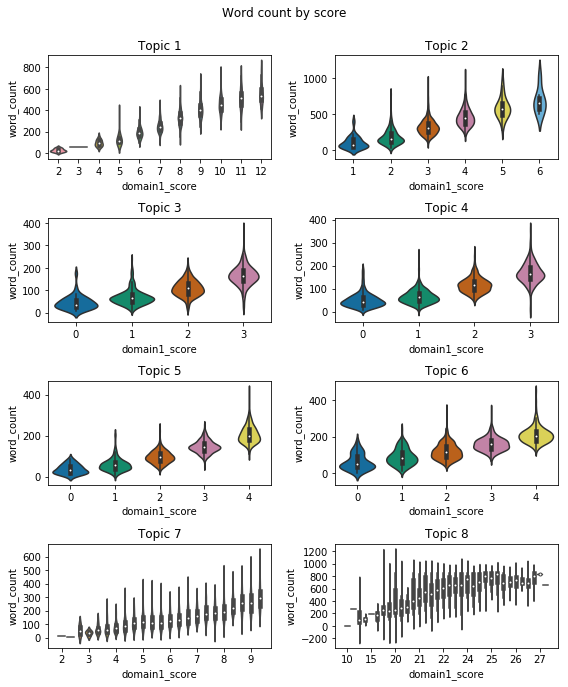

In [10]:
# correlation 
# Word count v/s score

topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(8,10))
for i in range(4):
    for j in range(2):
        topic_number += 1
        sns.violinplot(x='domain1_score', y='word_count', data=training_set[training_set['essay_set'] == topic_number], ax=ax[i,j])
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Word count by score')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

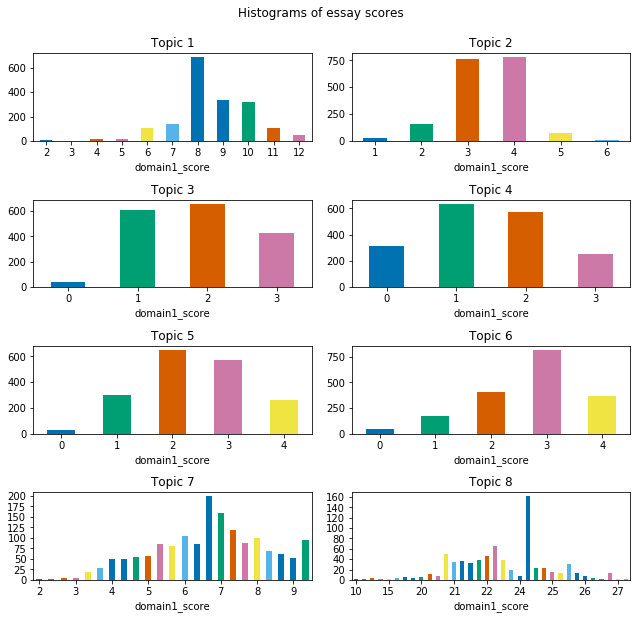

In [11]:
# Since scores are calculated on different scale for each essay set, 
# Quite a lot of scores are underrepresented and ranges differ invariably.

topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(9,9), sharey=False)
for i in range(4):
    for j in range(2):
        topic_number += 1
        training_set[training_set['essay_set'] == topic_number]\
            .groupby('domain1_score')['essay_id']\
            .agg('count')\
            .plot.bar(ax=ax[i, j], rot=0)
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Histograms of essay scores')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

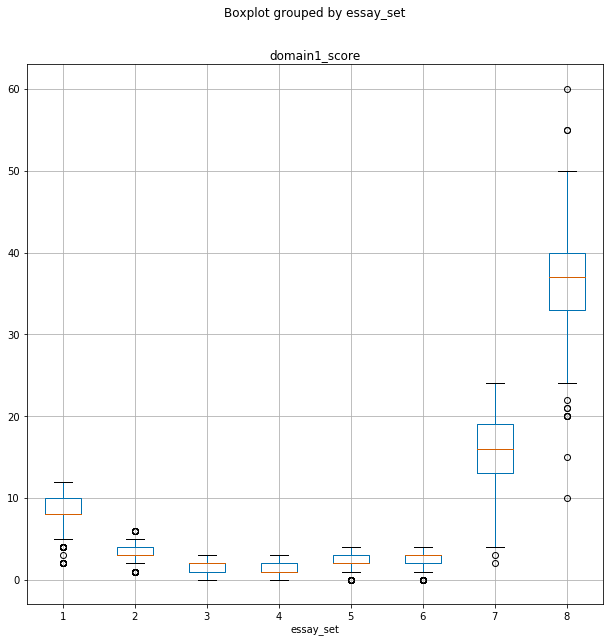

In [12]:
# Boxplot for target score across essay sets

training_set.boxplot(column = 'domain1_score', by = 'essay_set', figsize = (10, 10))